In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

path = '../dataset/preprocessed data sets 0407/'
df_train_dynamic = pd.read_csv(path+'train data/train_dynamic_knn_impute_0407.csv')
df_train_static = pd.read_csv(path+'train data/train_static_0407.csv')
df_test_dynamic = pd.read_csv(path+'test data/test_dynamic_knn_impute_0407.csv')
df_test_static = pd.read_csv(path+'test data/test_static_0407.csv')
df_static = pd.read_csv('../dataset/assignment2_data_with_outcome/patient_static.csv')
df_static = df_static.loc[:,['stay_id','gender','admission_age', 'los_icu', 'hospital_expire_flag','charlson_score']]
print('Train set sizes:', df_train_dynamic.shape, df_train_static.shape)
print('Testn set sizes:', df_test_dynamic.shape, df_test_static.shape)
print('Static set sizes:', df_static.shape)

c:\Users\admin\.conda\envs\py37-torch111\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Train set sizes: (4220, 23) (1212, 22)
Testn set sizes: (1791, 23) (515, 22)
Static set sizes: (3573, 6)


In [2]:
df_static['gender'] = df_static['gender'].apply(lambda x: 0 if x == 'M' else 1)
df_static['admission_age'] = df_static['admission_age'].apply(
    lambda x: int(x/10))
df_static['los_icu'] = df_static['los_icu'].apply(lambda x: int(x))

In [3]:
columns = df_train_dynamic.columns
feature_column_list = columns[9:]
feature_column_list

Index(['calcium', 'creatinine', 'glucose', 'sodium', 'chloride', 'hemoglobin',
       'wbc', 'alt', 'ast', 'alp', 'bilirubin_total', 'bilirubin_direct',
       'bilirubin_indirect', 'pt'],
      dtype='object')

In [4]:
train_X_dict = {}
train_X_dict_num = {}
test_X_dict = {}
test_X_dict_num = {}

for is_train, df in [(True, df_train_dynamic), (False, df_test_dynamic)]:
    dict_to_use = train_X_dict if is_train else test_X_dict
    dict_to_use_num = train_X_dict_num if is_train else test_X_dict_num
    for stay_id in df['stay_id'].unique():
        df_sample = df.loc[(df['stay_id'] == stay_id) & (
            df['charttime_hour'] >= -48), feature_column_list]
        dict_to_use[stay_id] = df_sample.reset_index(drop=True)
        dict_to_use_num[stay_id] = df_sample.shape[0]


def get_nan_60h_df(columns):
    df = pd.DataFrame(columns=columns)
    for i in range(30):
        df.loc[i] = np.nan
        df.loc[i, 'charttime_hour'] = -48 + 2 * i
    return df


def process_dynamic_df(df):
    nan_60h_df = get_nan_60h_df(columns)
    result_dict = {}
    for stay_id in df['stay_id'].unique():
        new_60h_df = nan_60h_df.copy()
        df_sample = df.loc[(df['stay_id'] == stay_id) & (
            df['charttime_hour'] >= -48), columns]
        df_sample['charttime_hour'] = df_sample['charttime_hour'] // 2 * 2

        for i in range(df_sample.shape[0]):
            tmp = df_sample.iloc[i]['charttime_hour']
            new_60h_df[new_60h_df['charttime_hour'] == tmp] = df_sample.iloc[i]

            tmp_df = new_60h_df.iloc[:, 3:].copy() 
            tmp_df = tmp_df.fillna(value=np.nan) 
            tmp_df.interpolate(
                method='linear',  limit_direction='both', inplace=True, axis=0)
            result_dict[stay_id] = tmp_df
    return result_dict


train_X_dict_time_series = process_dynamic_df(df_train_dynamic)
test_X_dict_time_series = process_dynamic_df(df_test_dynamic)


In [5]:
train_df_X = pd.DataFrame({'stay_id': df_train_static['stay_id'].values})
for key in train_X_dict_time_series.keys():
    train_df_X.loc[train_df_X['stay_id'] == key,
                   feature_column_list] = train_X_dict_time_series[key].iloc[-1, :][1:].values[5:]  

train_df_y = df_train_static[['stay_id', 'vent_duration']]

test_df_X = pd.DataFrame(columns=['stay_id', *feature_column_list])

test_df_X['stay_id'] = df_test_static['stay_id']

for key in test_X_dict_time_series.keys():
    test_df_X.loc[test_df_X['stay_id'] == key,
                  feature_column_list] = test_X_dict_time_series[key].iloc[-1, :][1:].values[5:] 
test_df_y = df_test_static[['stay_id', 'vent_duration']]


In [6]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
import xgboost as xgb
import lightgbm as lgb

# Vent_duration

In [7]:
# 🥳🥳🥳🥳🥳🥳
train_df_X = pd.merge(df_static, train_df_X, on='stay_id')
test_df_X = pd.merge(df_static, test_df_X, on='stay_id')
# 🥳🥳🥳🥳🥳🥳

train_df_X = train_df_X.fillna(train_df_X.median())
train_df_y = train_df_y.fillna(train_df_y.median())
test_df_X = test_df_X.fillna(test_df_X.median())
test_df_y = test_df_y.fillna(test_df_y.median())

train_X = train_df_X.iloc[:, 1:].values
train_y = train_df_y.iloc[:, 1:].values
test_X = test_df_X.iloc[:, 1:].values
test_y = test_df_y.iloc[:, 1:].values

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((1212, 19), (1212, 1), (515, 19), (515, 1))

In [8]:
def score_duration(y_pred ,gt_y):
    L1_abs_err = np.mean(abs(y_pred - gt_y))
    MSE = np.mean((y_pred - gt_y)**2)
    print('===================  VENTILATION vent_duration  ============================= ')
    print('Mean L1 error:', np.round(L1_abs_err, 2))
    print('Mean Square error:', np.round(MSE))

    print('================  VENTILATION vent_durationin 1, 2, 6, 12,24 ==================== ')
    gt_y = df_test_static[['vent_duration_1', 'vent_duration_2',
                           'vent_duration_6', 'vent_duration_12', 'vent_duration_24']].values
    h_list = [1, 2, 6, 12, 24]
    divisors = np.array([h_list]).reshape(1, -1)
    pred_divided = y_pred.reshape(-1, 1) // divisors
    accuracies = np.mean(pred_divided == gt_y, axis=0) * 100
    for i, h in enumerate(h_list):
        print('Accuracy at {} hours : {:.2f} %'.format(h, accuracies[i]))

In [9]:
xgbreg = xgb.XGBRegressor(
    learning_rate=0.0002,
    max_depth=20,
    max_leaves=24,
    n_estimators=1200,
    random_state=5,
    subsample=0.6,
    tree_method='gpu_hist'
)

xgbreg.fit(train_X, train_y)
y_pred_xgbreg = xgbreg.predict(test_X)

xgbreg.fit(train_X, train_y)
y_pred_xgbreg = xgbreg.predict(test_X)
score_duration(y_pred_xgbreg, test_y)

===================  VENTILATION vent_duration  ============================= 
Mean L1 error: 25.59
Mean Square error: 1886.0
================  VENTILATION vent_durationin 1, 2, 6, 12,24 ==================== 
Accuracy at 1 hours : 3.88 %
Accuracy at 2 hours : 8.16 %
Accuracy at 6 hours : 17.86 %
Accuracy at 12 hours : 30.87 %
Accuracy at 24 hours : 61.36 %


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


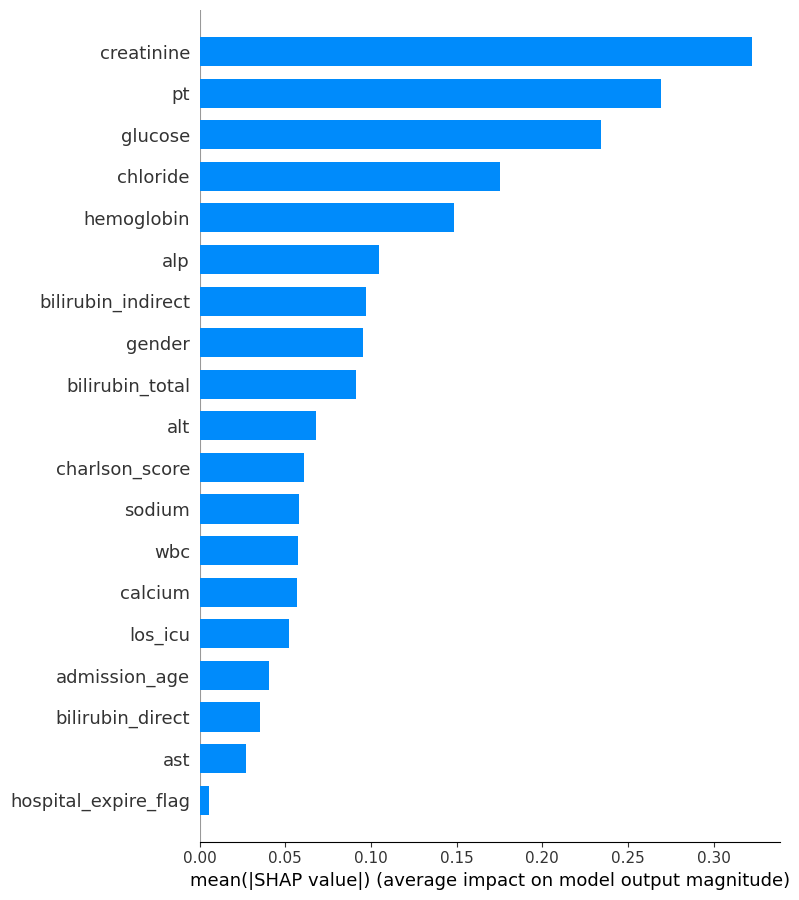

In [10]:
# 用SHAP来解释模型
import shap
cols = train_df_X.columns[1:]
shap.initjs()
explainer = shap.TreeExplainer(xgbreg)
shap_values = explainer.shap_values(test_X)
shap.summary_plot(shap_values, test_X, feature_names=cols, plot_type="bar")

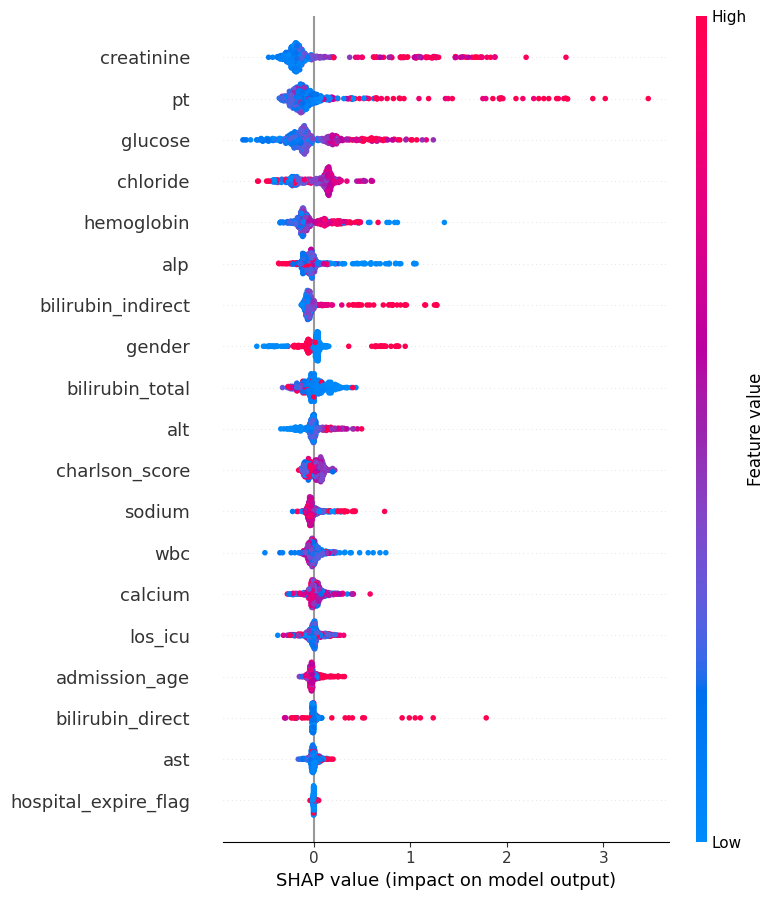

In [11]:
# 使用 SHAP进行可解释性分析
shap.summary_plot(shap_values, test_X, feature_names=cols)
